# This code is for our best performing models
Hi! These are our best performing models. The model tuning process is in another file, ask us about it if you're curious. 
Cheers

In [1]:
#imports only
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.discriminant_analysis as skl_da
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV,GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score,  make_scorer, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier



In [2]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=["near_fid"], axis=1) #drop near_fid as it doesnt make sense to have (is only an ID)
original_data = data.copy()
data.head()

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [3]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


# Data exploration

### Distance

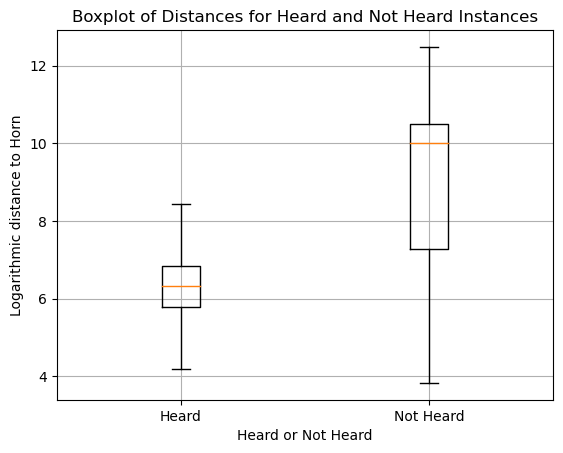

In [4]:
df = data

#Transforming distance by its logarithm to rescale distance to a format that is easier to see differences and handle outliers
data['dist_log'] = np.log(data['dist'])

#Variables related to plotting
log_dist_heard = df[df['heard'] == 1]['dist_log']
log_dist_not_heard = df[df['heard'] == 0]['dist_log']
all_distances = [log_dist_heard, log_dist_not_heard]
plt.boxplot(all_distances, labels=['Heard', 'Not Heard'], showfliers=False)
plt.title('Boxplot of Distances for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Logarithmic distance to Horn')
plt.grid(True)
plt.show()


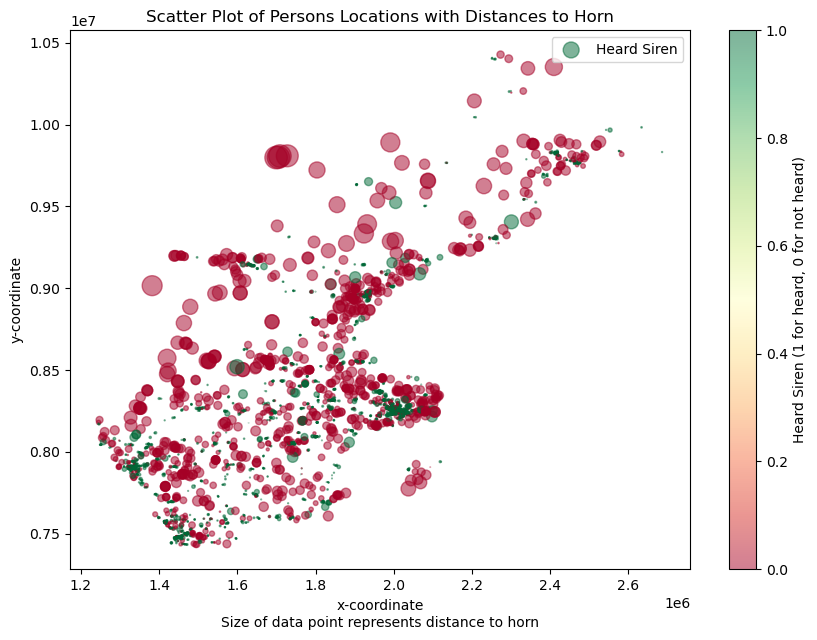

In [5]:
scaling_factor = 0.001  #scaling the distance as some distances are huge

#Plotting the coordinates of the person and the distance to horn and if the person heard the signal or not
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data["xcoor"], data["ycoor"], alpha=0.5, 
                      c=data["heard"], cmap='RdYlGn', label="Heard Siren",
                      s=data["dist"] * scaling_factor, marker='o')
plt.colorbar(scatter, label='Heard Siren (1 for heard, 0 for not heard)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Scatter Plot of Persons Locations with Distances to Horn')
plt.legend()

plt.text(0.5, -0.1, "Size of data point represents distance to horn", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


## Age

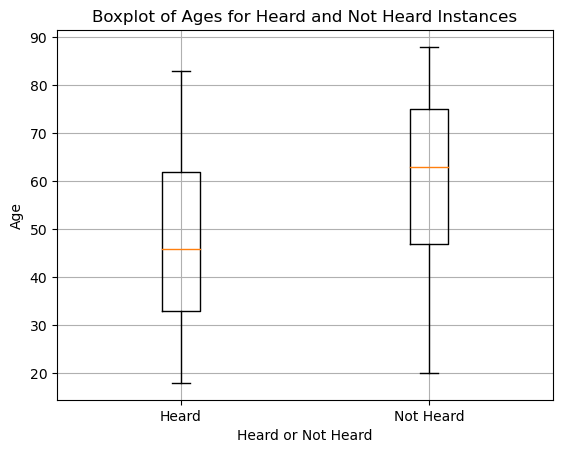

In [6]:
age_heard = data[data['heard'] == 1]['age']
age_not_heard = data[data['heard'] == 0]['age']

all_ages = [age_heard, age_not_heard]

plt.boxplot(all_ages, labels=['Heard', 'Not Heard'])
plt.title('Boxplot of Ages for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Age')
plt.grid(True)
plt.show()


### Angles

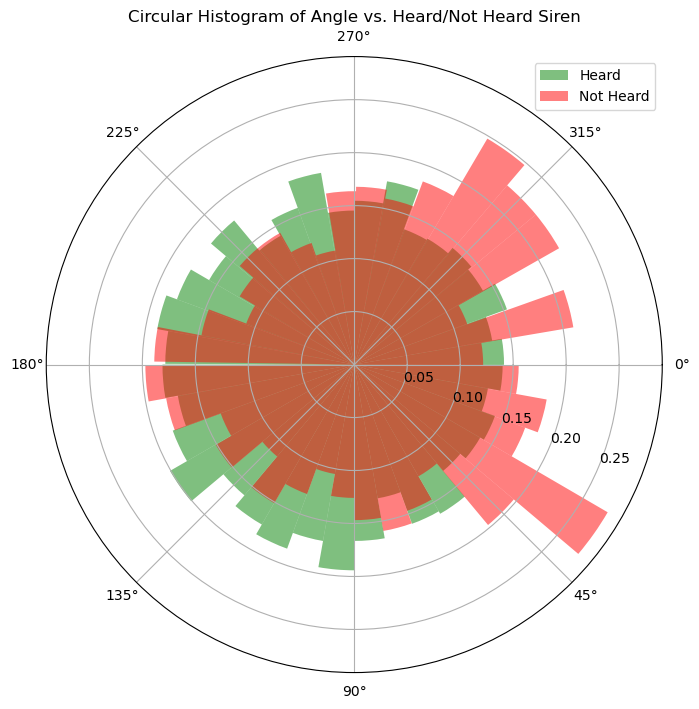

In [7]:
# Separate angles in heard and not heard signal
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Plot rose diagram
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.hist(np.radians(angles_heard), bins=36, density=True, alpha=0.5, color='green', label='Heard')
ax.hist(np.radians(angles_not_heard), bins=36, density=True, alpha=0.5, color='red', label='Not Heard')
ax.set_theta_direction(-1) #sets direction of the rose plot as clockwise
plt.legend()
plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')
plt.show()


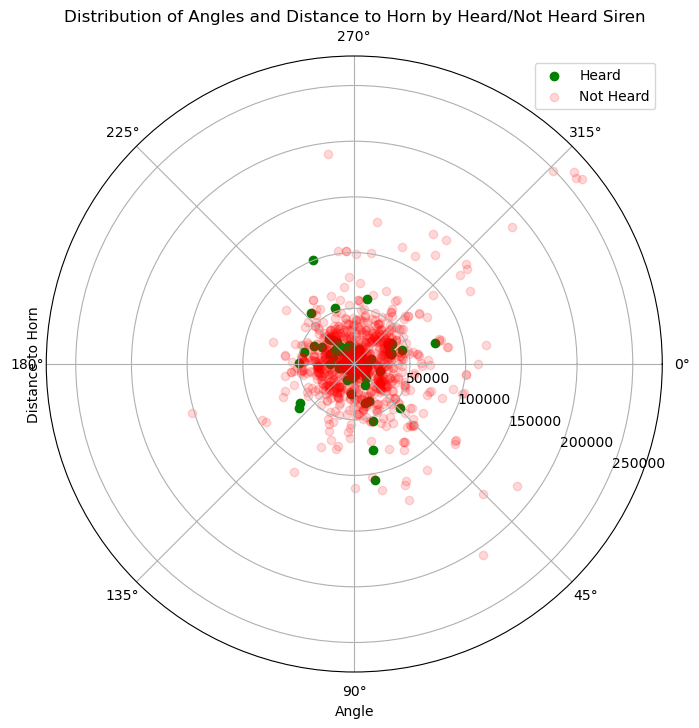

In [8]:
# Separate angles in heard and not heard signal
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

distances_heard = data[data['heard'] == 1]['dist']
distances_not_heard = data[data['heard'] == 0]['dist']

# Create a polar plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)
ax.scatter(np.radians(angles_heard), distances_heard, alpha=1, color='green', label='Heard')
ax.scatter(np.radians(angles_not_heard), distances_not_heard, alpha=0.15, color='red', label='Not Heard')
ax.set_theta_direction(-1) # Set the direction of the polar plot as clockwise
plt.xlabel('Angle')
plt.ylabel('Distance to Horn')
plt.title('Distribution of Angles and Distance to Horn by Heard/Not Heard Siren')
plt.legend()
plt.show()


# Creating age grouping

In [9]:
#new bins based on hearing with age research, see report why
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']
data['age_group'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)


In [10]:
data = pd.get_dummies(data, columns=["age_group"]) #splitting the age groups into their own binary columns
data.head(10)

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820,0,0,1,0,0
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362,1,0,0,0,0
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180,1,0,0,0,0
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201,1,0,0,0,0
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286,0,0,1,0,0
5,1.934971e+06,8.959613e+06,-159.477621,0,1,1938739.0,8961023,0,0,0,1,62,4023.130333,8.299816,0,0,0,1,0
6,1.327964e+06,7.940968e+06,18.712045,1,1,1327733.0,7940890,0,0,0,0,74,244.293455,5.498370,0,0,0,0,1
7,2.005312e+06,8.234592e+06,146.602179,1,0,2007113.0,8233405,0,0,0,0,24,2157.250580,7.676590,1,0,0,0,0
8,2.010260e+06,8.244737e+06,91.888991,1,0,2010284.0,8244010,0,0,0,0,66,727.512654,6.589631,0,0,0,1,0
9,1.339570e+06,7.892866e+06,160.654726,1,1,1340898.0,7892400,0,0,0,0,53,1407.236379,7.249383,0,0,1,0,0


# Generate train & test set

In [11]:
#random sampling with shuffling built-in
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


#create train and test
train, test = split_train_test(data, 0.20, data["heard"])

#creating X_train, X_test and y_train, y_test as y shall only have the column heard
X_train = train.drop(columns=['heard'])
y_train = train['heard']
X_test = test.drop(columns=['heard'])
y_test = test['heard']

In [12]:
X_train

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
1495,1.899983e+06,8.317943e+06,-159.031637,0,1900443.0,8318119,0,0,0,0,43,492.346276,6.199182,0,1,0,0,0
2241,1.443840e+06,7.477132e+06,-102.296590,0,1443895.0,7477382,0,0,0,0,76,256.367212,5.546611,0,0,0,0,1
608,1.925814e+06,8.952174e+06,59.939056,1,1925467.0,8951574,0,0,0,0,34,693.500524,6.541752,1,0,0,0,0
834,1.990362e+06,8.255945e+06,25.928404,1,1989657.0,8255602,0,0,0,0,68,783.405182,6.663650,0,0,0,1,0
3878,1.576943e+06,7.921562e+06,77.156274,1,1576830.0,7921066,0,0,0,0,47,508.843673,6.232141,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,2.011554e+06,8.250627e+06,-79.591837,0,2011506.0,8250890,0,0,0,0,27,266.907973,5.586904,1,0,0,0,0
1335,1.665069e+06,7.970683e+06,2.175124,0,1621975.0,7969046,0,0,0,0,81,43124.591154,10.671849,0,0,0,0,1
1612,1.769629e+06,8.265561e+06,-131.485060,1,1770248.0,8266261,0,0,0,0,36,935.080868,6.840633,1,0,0,0,0
5133,1.818135e+06,7.696121e+06,-139.448126,0,1818281.0,7696246,0,1,0,0,41,191.945000,5.257209,0,1,0,0,0


# Models

## LDA
Remove age groupings as that has a really high (infinity) VIF score as well as coordinates as they have a high VIF

In [13]:
#Checking VIF for entire dataset, see report why

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = X_train.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

           Variable          VIF
0            near_x   510.388784
1            near_y  1570.541123
2        near_angle     1.063686
3          building     1.162020
4             xcoor   507.164920
5             ycoor  1572.250768
6             noise     1.108657
7        in_vehicle     1.151242
8            asleep     1.032085
9        no_windows     1.108251
10              age    16.780296
11             dist     3.069256
12         dist_log     2.773053
13   age_group_0-39          inf
14  age_group_40-49          inf
15  age_group_50-59          inf
16  age_group_60-69          inf
17    age_group_70+          inf
18        Intercept     0.000000


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [14]:
#Best result of exploring different feature selections
columns_to_remove = ["dist", 'age_group_0-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70+']

X_train_LDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_LDA = X_test.drop(columns=columns_to_remove , axis=1)

In [15]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = X_train_LDA.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

      Variable          VIF
0       near_x   426.476865
1       near_y  1547.230777
2   near_angle     1.062723
3     building     1.161085
4        xcoor   420.530646
5        ycoor  1546.902818
6        noise     1.106274
7   in_vehicle     1.148864
8       asleep     1.029123
9   no_windows     1.104923
10         age     1.052773
11    dist_log     1.356496
12   Intercept   284.911462


In [16]:
def perform_LDA():
    np.random.seed(123)
    
    lda_model = skl_da.LinearDiscriminantAnalysis()
    lda_model.fit(X_train, y_train)

    scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
    }
    
    # Perform cross-validation
    cv_results_accuracy = cross_val_score(lda_model, X_train_LDA, y_train, cv=5, scoring='accuracy')
    cv_results = cross_validate(lda_model, X_train_LDA, y_train, cv=5, scoring=scoring)
    
    # Extract and store the cross-validation scores
    result_dict = {}
    result_dict['accuracy_cv'] = cv_results_accuracy.mean()
    result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
    result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
    result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
    result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])
    return result_dict

In [17]:
result_dict_lda = perform_LDA()
print("---- LDA 5fold cross validation ----")
print(result_dict_lda)


---- LDA 5fold cross validation ----
{'accuracy_cv': 0.9297291014066211, 'f1_cv': 0.9547742862471746, 'precision_cv': 0.9349078516592362, 'recall_cv': 0.9755275433831609, 'balanced_accuracy_cv': 0.8800012146139548}


### QDA

In [18]:
#Best result of exploring different feature selections
columns_to_remove = ['age_group_0-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70+', 'near_x', 'near_y', 'near_angle', 'building', 'xcoor', 'ycoor', "dist"]

X_train_QDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_QDA = X_test.drop(columns=columns_to_remove , axis=1)


In [19]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = X_train_QDA.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

     Variable        VIF
0       noise   1.105835
1  in_vehicle   1.130219
2      asleep   1.009789
3  no_windows   1.023048
4         age   1.051652
5    dist_log   1.216123
6   Intercept  23.414805


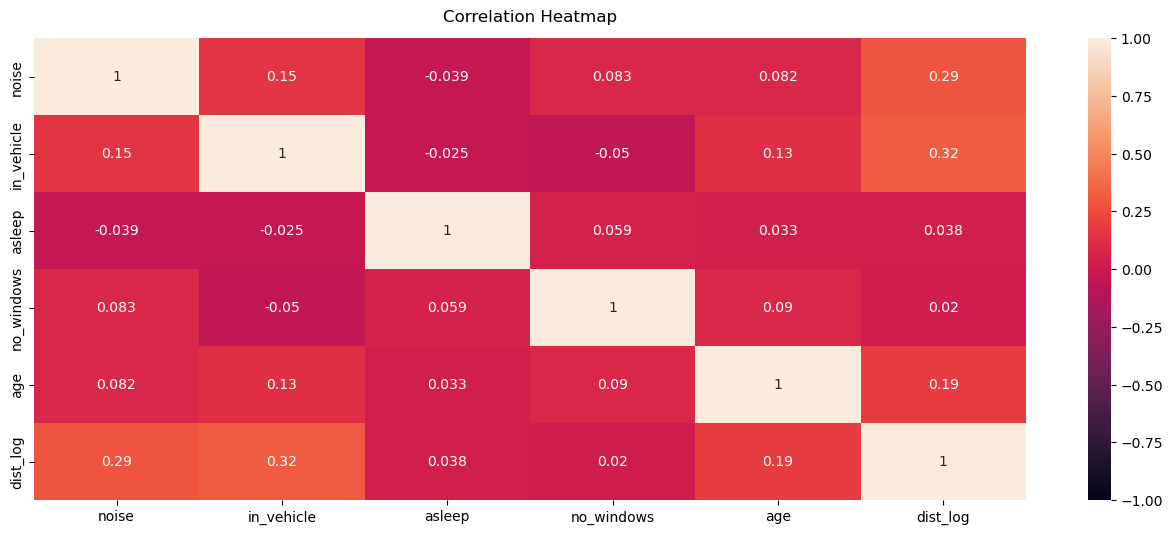

In [20]:
#Check correlation in our features for QDA
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train_QDA.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [21]:
def perform_QDA():
    
    pipeline = make_pipeline(skl_da.QuadraticDiscriminantAnalysis())
    
    # Define hyperparameters grid for QDA
    param_grid = {
        'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.5, 1.0]  # regularization parameter for QDA
    }

    np.random.seed(123)
    
    grid_search_qda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search_qda.fit(X_train_QDA, y_train)
    
    # Print the best hyperparameters and their corresponding score
    print("Best hyperparameters:", grid_search_qda.best_params_)
    
    # Use the best model obtained from grid search moving forward
    best_qda_model = grid_search_qda.best_estimator_

    scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
    }

    # Perform cross-validation
    cv_results_accuracy = cross_val_score(best_qda_model, X_train_QDA, y_train, cv=5, scoring='accuracy')
    cv_results = cross_validate(best_qda_model, X_train_QDA, y_train, cv=5, scoring=scoring)
    
    # Extract and store the cross-validation scores
    result_dict = {}
    result_dict['accuracy_cv'] = cv_results_accuracy.mean()
    result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
    result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
    result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
    result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])
    
    return result_dict

In [22]:
import warnings

# Ignore collinearity warnings
warnings.filterwarnings("ignore", category=UserWarning)

result_dict_QDA = perform_QDA()
print("---- QDA 5fold-cross-validation----") 
print(result_dict_QDA)

Best hyperparameters: {'quadraticdiscriminantanalysis__reg_param': 0.1}
---- QDA 5fold-cross-validation----
{'accuracy_cv': 0.9192217447470409, 'f1_cv': 0.9483260179439666, 'precision_cv': 0.9231201557345884, 'recall_cv': 0.9749511745070801, 'balanced_accuracy_cv': 0.858708463965869}


# Random Forest

In [23]:
def generate_feature_importances(model):
    #this gives each features importance in relation to the Random Forest model
    feature_importances = model_tree.feature_importances_
    feature_importance_dict = dict(zip(X_train.columns, feature_importances))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importances:")
    for feature, importance in sorted_feature_importance:
        print(f"{feature}: {importance}")


In [24]:
columns_to_remove = ['near_x', 'near_y', 'xcoor', 'ycoor', 'age_group_0-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70+']
X_train_RF = X_train.drop(columns=columns_to_remove , axis=1)
X_test_RF = X_test.drop(columns=columns_to_remove , axis=1)


In [26]:
# Defining the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]                # Minimum number of samples required at each leaf node
}

# Create grid search with these parameters
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_RF, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

#This is the best model used going forward
best_model = grid_search.best_estimator_

#Random Forest setup
model_tree = RandomForestClassifier(**best_params, random_state=42) #defining which modell to be used
model_tree.fit(X_train_RF, y_train)
model_tree_prediction = model_tree.predict(X_test_RF)

# Perform cross-validation
scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
}


cv_results_accuracy = cross_val_score(model_tree, X_train_RF, y_train, cv=5, scoring='accuracy')
cv_results = cross_validate(model_tree, X_train_RF, y_train, cv=5, scoring=scoring)   
    
# Extract and store the cross-validation scores
result_dict = {}
result_dict['accuracy_cv'] = cv_results_accuracy.mean()
result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])

print("---- Random Forest 5fold-cross-validation ----") 
print(result_dict)




Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best Score: 0.9316987065029563
---- Random Forest 5fold-cross-validation ----
{'accuracy_cv': 0.9316987065029563, 'f1_cv': 0.955708293021045, 'precision_cv': 0.9426232399669955, 'recall_cv': 0.9691928762465534, 'balanced_accuracy_cv': 0.8909891321872034}


In [27]:
generate_feature_importances(model_tree)

Feature Importances:
asleep: 0.3305902611946721
in_vehicle: 0.3249534913145726
noise: 0.07755079922769935
building: 0.07392604033869393
ycoor: 0.06416600209393113
near_x: 0.05214655221481001
near_angle: 0.05171267979267399
xcoor: 0.0200913939001569
near_y: 0.004862779922790031


# Logistic Regression

In [35]:
#Exclusion of features for best performing logistic
#columns_to_remove = ["dist", 'age_group_0-39', 'age_group_40-49', 'age_group_50-59',
      # 'age_group_60-69', 'age_group_70+', 'near_x', 'near_y', 'xcoor', 'ycoor']
columns_to_remove = ["dist", 'age_group_0-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70+', 'near_x', 'near_y', 'xcoor', 'ycoor']

X_train_LR = X_train.drop(columns=columns_to_remove , axis=1)
X_test_LR = X_test.drop(columns=columns_to_remove , axis=1)

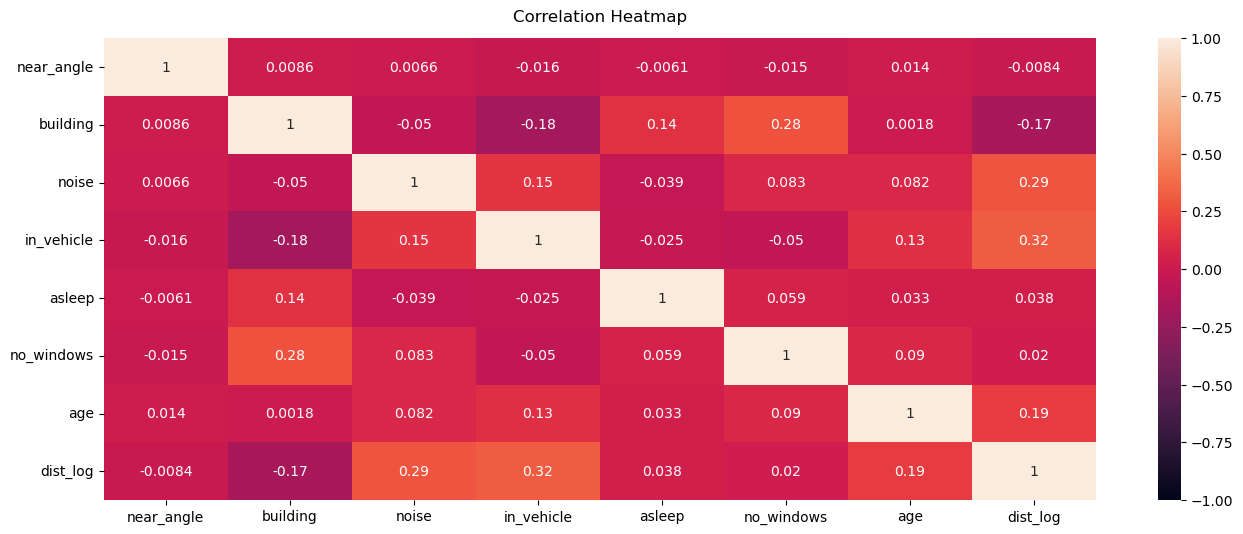

In [36]:
# Check for correlations in features used for logistic 
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train_LR.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [37]:
#Grid Search for optimal Logistic Regression model

# Define which parameters to search over
grid_parameters = {
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [3000, 5000, 10000],
    'penalty': ['l2']  # Add penalty options
}

#  logistic regression classifier
log_reg = LogisticRegression()

# our grid search
grid_search = GridSearchCV(estimator=log_reg,  param_grid=grid_parameters, cv=3, scoring='roc_auc', n_jobs = -1)

# Using scaler to normalize the input, otherwise the model may not converge
scaler = StandardScaler()
X_train_LR_scaled = scaler.fit_transform(X_train_LR)
X_test_LR_scaled = scaler.transform(X_test_LR)

#fit grid search to our data
grid_search.fit(X_train_LR_scaled, y_train) #train the model on all grid paramaters

# Get best parameters and best score
tuned_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyper parameters:", tuned_parameters)
print(f"Best Score for traning data:, {best_score:.4f}")

#Work with best model moving forward
best_logreg_model = grid_search.best_estimator_
best_logreg_model.fit(X_train_LR_scaled, y_train) #train model on best parameters

#predict X_test for best estimator
logreg_grid_pred = best_logreg_model.predict_proba(X_test_LR_scaled) # predicts X test values
predicted_logreg_grid = np.where(logreg_grid_pred[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
acc_logreg_grid = np.mean(predicted_logreg_grid == y_test) #accuracy for logistic reg model from grid search


Best Hyper parameters: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best Score for traning data:, 0.9516


In [40]:
# As SAGA was the best solver, we redo the grid search with only that solver but add penalty l1 as it is only suitable for that solver
# This to make sure we have the optimal setup

# Define which parameters to search over
grid_parameters = {
    'solver': ['saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [3000, 5000, 10000],
    'penalty': ['l1','l2']  # Add penalty options
}

#  logistic regression classifier
log_reg = LogisticRegression()

# our grid search
grid_search = GridSearchCV(estimator=log_reg,  param_grid=grid_parameters, cv=3, scoring='roc_auc', n_jobs = -1)

# Using scaler to normalize the input, otherwise the model may not converge
scaler = StandardScaler()
X_train_LR_scaled = scaler.fit_transform(X_train_LR)
X_test_LR_scaled = scaler.transform(X_test_LR)

#fit grid search to our data
grid_search.fit(X_train_LR_scaled, y_train) #train the model on all grid paramaters

# Get best parameters and best score
tuned_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyper parameters:", tuned_parameters)
print(f"Best Score for traning data:, {best_score:.4f}")

#Work with best model moving forward
best_logreg_model = grid_search.best_estimator_
best_logreg_model.fit(X_train_LR_scaled, y_train) #train model on best parameters

#predict X_test for best estimator
logreg_grid_pred = best_logreg_model.predict_proba(X_test_LR_scaled) # predicts X test values
predicted_logreg_grid = np.where(logreg_grid_pred[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
acc_logreg_grid = np.mean(predicted_logreg_grid == y_test) #accuracy for logistic reg model from grid search


Best Hyper parameters: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best Score for traning data:, 0.9516


best threshold:  0.4
---- Logistic Regression 5fold-cross-validation ----
{'accuracy_cv': 0.8839759275814216, 'f1_cv': 0.9280690246368245, 'precision_cv': 0.8808101884401038, 'recall_cv': 0.9807107167292104, 'balanced_accuracy_cv': 0.7798530752595824}


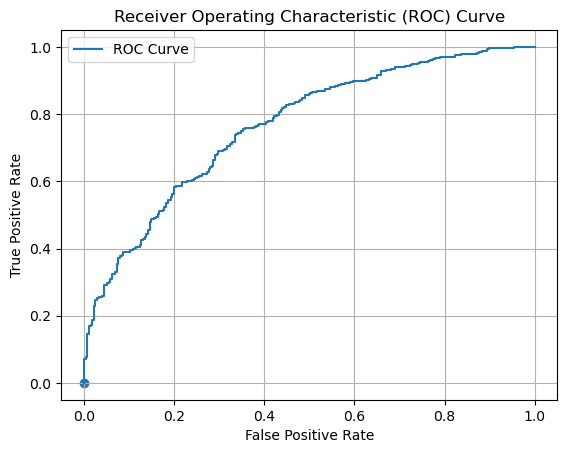

In [41]:
#How the threshold value affects the ROC for Logistic regression

threshold_values = [0.3, 0.4, 0.5, 0.6, 0.7] #Different threshold values
best_score = 0 

for threshold in threshold_values: 
    predicted_logreg_threshold = (logreg_grid_pred[:, 1] >= threshold).astype(int) #creats boolean array and converts it to 0 or 1 
    logreg_score = accuracy_score(y_test, predicted_logreg_threshold) #takes the accuracy_score for the different thresholds
    if logreg_score > best_score: #if the acc score is better than best_score, replace
        best_score = logreg_score
        best_threshold = threshold

# Use the best threshold for predictions on the test data
logreg_grid_pred_test = best_logreg_model.predict_proba(X_test_LR)
pred_logreg_grid_test = (logreg_grid_pred_test[:, 1] >= best_threshold).astype(int)
acc_logreg_grid_test = np.mean(pred_logreg_grid_test == y_test)
auc_score_logreg = roc_auc_score(y_test, predicted_logreg_threshold)

fpr, tpr, thresholds = roc_curve(y_test, logreg_grid_pred_test[:, 1]) #takes the false and negative positive and rate

best_threshold_index = np.argmax(thresholds >= best_threshold)
print("best threshold: ", best_threshold)

# ------ Validate results
# Perform cross-validation
scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
}


cv_results_accuracy = cross_val_score(best_logreg_model, X_train_LR, y_train, cv=5, scoring='accuracy')
cv_results = cross_validate(best_logreg_model, X_train_LR, y_train, cv=5, scoring=scoring)   
    
# Extract and store the cross-validation scores
result_dict = {}
result_dict['accuracy_cv'] = cv_results_accuracy.mean()
result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])

print("---- Logistic Regression 5fold-cross-validation ----") 
print(result_dict)


#ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()



# k-NN

In [42]:
# Different values of n with gridseach

# creating pipeline with scaling and KNN
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# our hyperparameters for kNN
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 201)),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'kneighborsclassifier__weights': ['uniform', 'distance']  
}

# Do grid search and fit to our data
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# This is the best model, used onwards
best_model = grid_search.best_estimator_

# Get the best k value and weights
best_k = grid_search.best_params_['kneighborsclassifier__n_neighbors']
best_metric = grid_search.best_params_['kneighborsclassifier__metric']
best_weights = grid_search.best_params_['kneighborsclassifier__weights']

# Predictions on the test set
test_predictions = best_model.predict(X_test)

# Print best k, best metric, and best weights
print(f"Best k Value: {best_k}")
print(f"Best Metric: {best_metric}")
print(f"Best Weights: {best_weights}")

# Perform cross-validation
scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
}


cv_results_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring)   
    
# Extract and store the cross-validation scores
result_dict = {}
result_dict['accuracy_cv'] = cv_results_accuracy.mean()
result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])

print("---- k-NN with 5fold-cross-validation ----") 
print(result_dict)


Best k Value: 18
Best Metric: euclidean
Best Weights: distance
---- k-NN with 5fold-cross-validation ----
{'accuracy_cv': 0.9203155969811213, 'f1_cv': 0.9490205525351157, 'precision_cv': 0.9239363545522782, 'recall_cv': 0.9755279580370285, 'balanced_accuracy_cv': 0.8603667187445417}


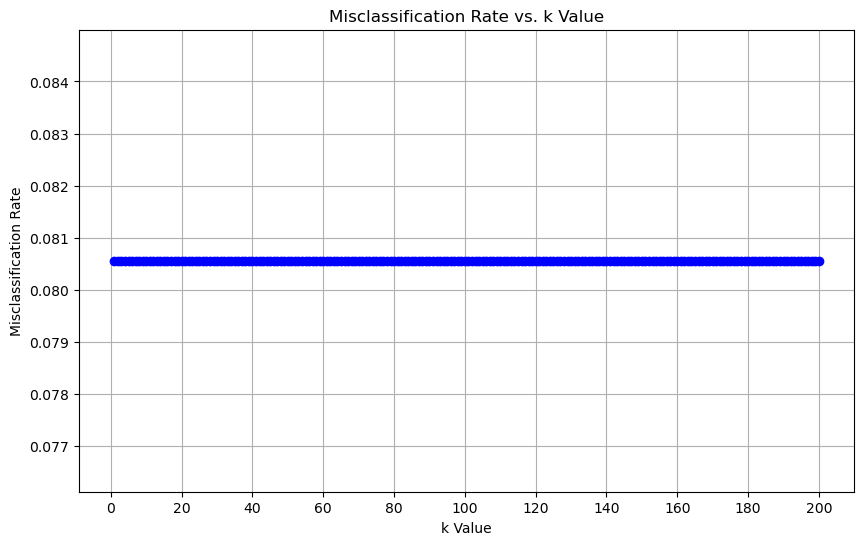

In [43]:
#plot misclassification rate, a bit unnecessary but plotted it with manual before as well
# Lists to store results
missclassification_rates = []
k_values = []

# Perform grid search with cross-validation
for k in range(1, 201):
    # Use the best_model for predictions
    prediction = best_model.predict(X_test)
    missclassification_rate = np.mean(prediction != y_test)
    missclassification_rates.append(missclassification_rate)
    k_values.append(k)

# Plot misclassification rate
plt.figure(figsize=(10, 6))
plt.plot(k_values, missclassification_rates, marker='o', linestyle='-', color='b')
plt.title('Misclassification Rate vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Misclassification Rate')
plt.xticks(range(0, 201, 20))
plt.grid(True)
plt.show()


# AdaBoost

In [44]:
def perform_adaboost(X_train, X_test):

    random_seed = 42
    
    # Define the pipeline
    pipeline = Pipeline([
        ('adaboost', AdaBoostClassifier(random_state=random_seed))  # AdaBoostClassifier
    ])
    
    # Define the hyperparameter grid for adaboost
    param_grid = {
        'adaboost__n_estimators': [50, 100, 200, 300],  # Number of estimators for AdaBoostClassifier
        'adaboost__learning_rate': [0.01, 0.1, 1.0, 2, 5, 10]  # Learning rate for AdaBoostClassifier
    }
    
    # Grid search is performed
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_boost = grid_search.best_estimator_
    
    # Print the best estimator and its hyperparameters
    print("Best Estimator: ", grid_search.best_estimator_)
    
    scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
    }
    
    # Adaboost classifier
    boost = AdaBoostClassifier(random_state=random_seed, n_estimators=best_boost.named_steps['adaboost'].n_estimators, learning_rate=best_boost.named_steps['adaboost'].learning_rate)
    
    # Perform cross-validation
    cv_results_accuracy = cross_val_score(boost, X_train, y_train, cv=5, scoring='accuracy')
    cv_results = cross_validate(boost, X_train, y_train, cv=5, scoring=scoring)
    
    
    # Extract and store the cross-validation scores
    result_dict = {}
    result_dict['accuracy_cv'] = cv_results_accuracy.mean()
    result_dict['f1_cv'] = np.mean(cv_results['test_f1'])
    result_dict['precision_cv'] = np.mean(cv_results['test_precision'])
    result_dict['recall_cv'] = np.mean(cv_results['test_recall'])
    result_dict['balanced_accuracy_cv'] = np.mean(cv_results['test_balanced_accuracy'])
    return result_dict

    
    

In [45]:
perform_adaboost(X_train, X_test)

Best Estimator:  Pipeline(steps=[('adaboost',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])


{'accuracy_cv': 0.9286350095029011,
 'f1_cv': 0.9539910713731887,
 'precision_cv': 0.9355230070958843,
 'recall_cv': 0.9732241411481766,
 'balanced_accuracy_cv': 0.8802193765101614}

# Get prediction of the test set for the best performing model


In [46]:
file_path = 'test_without_labels.csv'
data_to_predict = pd.read_csv(file_path)
data_to_predict = data_to_predict.drop(columns=["near_fid"], axis=1) #drop near_fid as it doesnt make sense to have (is only an ID)
data_to_predict

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2482435.777,9839068.274,-51.358358,0,2447980,9882166,0,0,0,0,72
1,2402521.073,9838093.818,-41.606385,0,2332300,9900453,1,0,0,0,57
2,2402521.073,9838093.818,-39.422879,0,2326359,9900705,0,1,0,0,42
3,2466575.866,9767285.065,64.628406,0,2466260,9766619,0,0,0,0,39
4,2480107.863,9835976.343,43.041199,0,2457330,9814705,0,0,0,0,68
...,...,...,...,...,...,...,...,...,...,...,...
630,1536761.452,7445577.374,-109.600534,0,1536918,7446017,0,0,0,0,73
631,1536761.452,7445577.374,-114.411924,0,1536951,7445995,0,0,0,0,69
632,1461772.301,7434825.576,-101.362172,0,1461860,7435262,0,1,0,0,49
633,1464447.086,7434699.214,151.746317,0,1464855,7434480,0,1,0,0,74


In [47]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data_to_predict['dist'] = np.sqrt((data_to_predict['xcoor'] - data_to_predict['near_x'])**2 + (data_to_predict['ycoor'] - data_to_predict['near_y'])**2)

#Transforming distance by its logarithm to rescale distance to a format that is easier to see differences and handle outliers
data_to_predict['dist_log'] = np.log(data_to_predict['dist'])


In [48]:
#new bins based on hearing with age research, see report why
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']
data_to_predict['age_group'] = pd.cut(data_to_predict['age'], bins=new_age_bins, labels=new_age_labels, right=False)


In [49]:
data_to_predict= pd.get_dummies(data_to_predict, columns=["age_group"]) #splitting the age groups into their own binary columns
data_to_predict.head(10)

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,2482435.777,9839068.274,-51.358358,0,2447980,9882166,0,0,0,0,72,55178.026016,10.918320,0,0,0,0,1
1,2402521.073,9838093.818,-41.606385,0,2332300,9900453,1,0,0,0,57,93913.080415,11.450125,0,0,1,0,0
2,2402521.073,9838093.818,-39.422879,0,2326359,9900705,0,1,0,0,42,98594.226378,11.498768,0,1,0,0,0
3,2466575.866,9767285.065,64.628406,0,2466260,9766619,0,0,0,0,39,737.166137,6.602813,1,0,0,0,0
4,2480107.863,9835976.343,43.041199,0,2457330,9814705,0,0,0,0,68,31165.703520,10.347074,0,0,0,1,0
5,2574988.694,9842218.491,-132.722511,0,2602262,9871751,0,0,0,0,71,40199.531191,10.601611,0,0,0,0,1
6,2415739.149,9835561.958,-152.038821,0,2416359,9835891,0,0,0,0,73,701.771971,6.553609,0,0,0,0,1
7,2418781.622,9828421.416,-115.298255,0,2419221,9829351,0,0,0,0,43,1028.192317,6.935558,0,1,0,0,0
8,2418022.423,9824262.498,156.830651,1,2418790,9823934,0,0,0,0,54,834.916395,6.727332,0,0,1,0,0
9,2410920.796,9828232.246,101.249844,0,2411075,9827457,0,0,0,0,57,790.433574,6.672582,0,0,1,0,0


In [50]:
data_to_predict

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,2482435.777,9839068.274,-51.358358,0,2447980,9882166,0,0,0,0,72,55178.026016,10.918320,0,0,0,0,1
1,2402521.073,9838093.818,-41.606385,0,2332300,9900453,1,0,0,0,57,93913.080415,11.450125,0,0,1,0,0
2,2402521.073,9838093.818,-39.422879,0,2326359,9900705,0,1,0,0,42,98594.226378,11.498768,0,1,0,0,0
3,2466575.866,9767285.065,64.628406,0,2466260,9766619,0,0,0,0,39,737.166137,6.602813,1,0,0,0,0
4,2480107.863,9835976.343,43.041199,0,2457330,9814705,0,0,0,0,68,31165.703520,10.347074,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,1536761.452,7445577.374,-109.600534,0,1536918,7446017,0,0,0,0,73,466.667222,6.145616,0,0,0,0,1
631,1536761.452,7445577.374,-114.411924,0,1536951,7445995,0,0,0,0,69,458.628303,6.128240,0,0,0,1,0
632,1461772.301,7434825.576,-101.362172,0,1461860,7435262,0,1,0,0,49,445.148315,6.098408,0,1,0,0,0
633,1464447.086,7434699.214,151.746317,0,1464855,7434480,0,1,0,0,74,463.085963,6.137913,0,0,0,0,1


## Create RF with optimal parameters and input

In [56]:
columns_to_remove = ['near_x', 'near_y', 'xcoor', 'ycoor', 'age_group_0-39', 'age_group_40-49', 'age_group_50-59',
       'age_group_60-69', 'age_group_70+']
X_train_RF = X_train.drop(columns=columns_to_remove , axis=1)
X_test_RF = X_test.drop(columns=columns_to_remove , axis=1)

data_to_predict_removed_features = data_to_predict.drop(columns=columns_to_remove, axis=1)


In [54]:
# Re-run RF grid search to have those values filled in the variable

# Defining the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]                # Minimum number of samples required at each leaf node
}

# Create grid search with these parameters
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_RF, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

#This is the best model used going forward
best_model = grid_search.best_estimator_

#Random Forest setup
model_tree = RandomForestClassifier(**best_params, random_state=42) #defining which modell to be used
model_tree.fit(X_train_RF, y_train)
model_tree_prediction = model_tree.predict(X_test_RF)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best Score: 0.9316987065029563


In [62]:
#Predict on testdata

new_data_predictions = best_model.predict(data_to_predict_removed_features)
#new_data_predictions

# Assuming new_data_predictions is your array of predictions
# Convert predictions to a single row of comma-separated values
predictions_str = ','.join(map(str, new_data_predictions))

# Save predictions to a CSV file
with open('predictions_group21_randomforest.csv', 'w') as file:
    file.write(predictions_str)

In [65]:
# double checking the file
with open('predictions_group21_randomforest.csv', 'r') as file:
    csv_length = len(file.readline().strip().split(','))

print("Length of CSV:", csv_length)

Length of CSV: 635


# Extras

In [66]:
#this is our custom built feature selector
def run_feature_selector(column_array):
    for column in column_array:
        column_to_remove = column
        print("Column that was removed: ", column)
        columns_to_remove = [column]
        X_train_temp = X_train_LDA.copy().drop(columns=columns_to_remove, axis=1)
        y_train_temp = y_train
        
        # Extract features and target for testing set
        X_test_temp = X_test_LDA.copy().drop(columns=columns_to_remove, axis=1)
        y_test_temp = y_test
    
        lda_model = skl_da.LinearDiscriminantAnalysis()
        lda_model.fit(X_train_temp, y_train_temp)
    
        predict_prob_lda = lda_model.predict_proba(X_test_temp)
    
        prediction_lda = np.empty(len(X_test_temp), dtype=object)
        prediction_lda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
        
        #Accuracy
        print(f"Accuracy: {np.mean(prediction_lda == y_test_temp):.3f}")




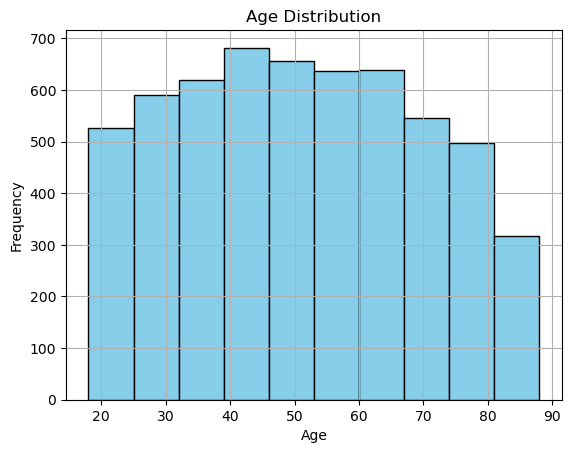

In [67]:
# This shows the distribution of age, which is a figure shown in appendix
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is stored in a pandas DataFrame called 'df' and the age column is named 'age'
# Example:
# df = pd.read_csv('your_dataset.csv')

# Plotting the histogram
plt.hist(data['age'], bins=10, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()